# GraphMERT Training Notebook
This notebook trains a Heterogeneous Graph Attention Transformer (GraphMERT) using PyTorch.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json

### Load Corpus and encode with SentenceTransformer - SBERT

 corpus is from Romeo and Juliet for free from gutenberg:
 https://www.gutenberg.org/ebooks/1513.txt.utf-8

In [16]:

import json
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np

# Load Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Split into sentences (a simple approach)
# import nltk
# nltk.download('punkt')
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')


from nltk import sent_tokenize

# Load large text corpus from a .txt file (e.g., downloaded from Project Gutenberg)
with open("/content/pg_sample_book.txt", "r", encoding="utf-8") as file:
    text = file.read()

sentences = sent_tokenize(text)

# Now you can use sentences as your corpus list instead of a small example list
corpus = sentences


# Example corpus with at least 10 sentences
# corpus = [
#     "Deep learning models revolutionize AI research.",
#     "Graph neural networks effectively process relational data.",
#     "Natural language processing benefits from transformers.",
#     "PyTorch offers dynamic computation graphs.",
#     "Embedding layers convert tokens into vectors."
# ]

seq_len = 5
original_dim = model.get_sentence_embedding_dimension()  # Typically 384
target_dim = 10  # as per your JSON structure

# Step 1: Encode all sentences using the Sentence Transformer
embeddings = model.encode(corpus)

# Step 2: Reduce 384-dim embeddings to 10-dim using PCA
pca = PCA(n_components=target_dim)
reduced_embeddings = pca.fit_transform(embeddings)

graphs = []
num_graphs = (len(reduced_embeddings) + seq_len - 1) // seq_len

for i in range(num_graphs):
    start = i * seq_len
    end = min(len(reduced_embeddings), (i + 1) * seq_len)
    chunk = reduced_embeddings[start:end].tolist()

    # Pad with zero vectors if less than seq_len
    while len(chunk) < seq_len:
        chunk.append([0.0] * target_dim)

    # Labels matching your example pattern (length=5)
    if i == 0:
        labels = [1, 0, 2, 1, 0]
    else:
        labels = [0, 1, 0, 2, 1]

    graphs.append({
        "features": chunk,
        "labels": labels
    })

# Save final dataset JSON exactly like your example structure
with open("sentence_transformer_fixed10d_graphs.json", "w") as f:
    json.dump(graphs, f, indent=2)

print(f"Saved {len(graphs)} graph examples to sentence_transformer_fixed10d_graphs.json")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saved 634 graph examples to sentence_transformer_fixed10d_graphs.json


### Run Training

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# H-GAT Layer with consistent dims
class HeteroGraphAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.attention_heads = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim // num_heads, num_heads=1, batch_first=True)
            for _ in range(num_heads)
        ])

    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        x_proj = self.linear(x)
        splits = torch.chunk(x_proj, self.num_heads, dim=-1)
        head_outputs = []
        for split, attn in zip(splits, self.attention_heads):
            out, _ = attn(split, split, split)
            head_outputs.append(out)
        return torch.cat(head_outputs, dim=-1)

# GraphMERT Encoder
class GraphMERTEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_layers, num_heads):
        super().__init__()
        self.total_embed_dim = embed_dim * num_heads
        self.embedding = nn.Linear(input_dim, self.total_embed_dim)
        self.hgat_layers = nn.ModuleList([
            HeteroGraphAttentionLayer(self.total_embed_dim, num_heads=num_heads)
            for _ in range(num_layers)
        ])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.total_embed_dim, nhead=num_heads, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.embedding(x)
        for hgat in self.hgat_layers:
            x = hgat(x)
        x = self.transformer_encoder(x)
        return x

# Synthetic dataset matching model input/output shapes
# class ChainGraphDataset(Dataset):
#     def __init__(self, num_samples=100, seq_len=5, feature_dim=10, num_classes=10):
#         self.features = torch.randn(num_samples, seq_len, feature_dim)
#         self.labels = torch.randint(0, num_classes, (num_samples, seq_len))

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

class ChainGraphDataset(Dataset):
    def __init__(self, json_path):
        import json
        with open(json_path, 'r') as f:
            self.chain_graphs = json.load(f)

    def __len__(self):
        return len(self.chain_graphs)

    def __getitem__(self, idx):
        example = self.chain_graphs[idx]
        features = torch.tensor(example["features"], dtype=torch.float)
        labels = example.get("labels")
        if labels is not None:
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            labels = torch.full((features.shape[0],), -100, dtype=torch.long)
        return features, labels


# Training loop with loss and optimizer
def train_graphmert(model, dataloader, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    for epoch in range(num_epochs):
        total_loss = 0
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)  # (batch, seq_len, embed_dim*num_heads)
            logits = outputs.view(-1, outputs.size(-1))
            loss = criterion(logits, labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

if __name__ == "__main__":
    input_dim = 10
    embed_dim = 32
    num_heads = 4  # should be a divisor of total embedding dimension and even for multihead attention
    num_layers = 2
    batch_size = 8
    num_epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # for Synthetic dataset matching model input/output shapes
      # dataset = ChainGraphDataset(num_samples=100, seq_len=5, feature_dim=input_dim, num_classes=10)
      # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset = ChainGraphDataset("/content/sentence_transformer_fixed10d_graphs.json")
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    model = GraphMERTEncoder(input_dim, embed_dim, num_layers, num_heads)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_graphmert(model, dataloader, optimizer, num_epochs, device)

    # Save the trained model weights
    save_path = "graphmert_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    torch.save(class_head.state_dict(), "graphmert_classifier_head.pth")
    print(f"class_head Model saved to graphmert_classifier_head.pth")



### *Inference*

In [36]:
# STEP 1: Load trained model weights
input_dim = 10
embed_dim = 32
num_heads = 4
num_layers = 2
model_path = "/content/graphmert_model.pth"

model = GraphMERTEncoder(input_dim, embed_dim, num_layers, num_heads)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# STEP 2: Prepare input text corpus to embeddings
# Load large text corpus from a .txt file (e.g., downloaded from Project Gutenberg)
with open("/content/pg_sample_book.txt", "r", encoding="utf-8") as file:
    text = file.read()

sentences = sent_tokenize(text)

# Now you can use sentences as your corpus list instead of a small example list
corpus = sentences

# Use SBERT to get fixed-size embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(corpus)  # shape approx (5,384)

# STEP 3: Reduce dimension to 10 with PCA (to match input_dim)
n_components = min(input_dim, embeddings.shape[0], embeddings.shape[1])
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings)  # (5,10)

# STEP 4: Convert to tensor and shape (1 batch, 5 nodes, 10 features)
input_features = torch.tensor([reduced_embeddings], dtype=torch.float32)  # Shape: (1,5,10)

# STEP 5: Inference
with torch.no_grad():
    outputs = model(input_features)  # Shape: (1, 5, embed_dim * num_heads)
    print("Inference output shape:", outputs.shape)
    print("Inference output tensor:", outputs)


Inference output shape: torch.Size([1, 3166, 128])
Inference output tensor: tensor([[[  6.2128,   6.1234,   5.4993,  ...,  -8.5211,  -7.0693, -11.4058],
         [  6.2128,   6.1234,   5.4993,  ...,  -8.5211,  -7.0693, -11.4058],
         [  6.2128,   6.1234,   5.4993,  ...,  -8.5211,  -7.0693, -11.4058],
         ...,
         [  6.2128,   6.1234,   5.4993,  ...,  -8.5211,  -7.0693, -11.4058],
         [  6.2128,   6.1234,   5.4993,  ...,  -8.5211,  -7.0693, -11.4058],
         [  6.2128,   6.1234,   5.4993,  ...,  -8.5211,  -7.0693, -11.4058]]])


In [ ]:
# Assuming 'corpus' is your list of input sentences or text chunks fed to the model
outputs_np = outputs[0].cpu().numpy()  # shape: (3166, 128)

for idx, embedding in enumerate(outputs_np):
    text_unit = corpus[idx]  # original text corresponding to node idx
    print(f"Text unit #{idx}: {text_unit}")
    print(f"Embedding vector sample: {embedding[:5]}...")  # show first 5 dims for brevity


## Analysis of GraphMERT KG created model

### Perform classification on output embeddings

In [ ]:
import torch
import torch.nn as nn

# Assume `outputs` is your GraphMERT encoder inference output with shape (1, N, 128)
# and `corpus` is your list of N text inputs (sentences, nodes, etc.)
# Example:
# outputs = model(input_features)
# corpus = ["sentence 1", "sentence 2", ..., "sentence N"]

num_classes = 5  # number of categories you want the head to predict

# Create (or load) classifier head
class_head = nn.Linear(128, num_classes)  # 128 matches your embedding dimension
# optional: if fine-tuned head weights exist
# class_head.load_state_dict(torch.load("graphmert_classifier_head.pth", map_location="cpu"))
class_head.eval()

# Step 1. Feed GraphMERT embeddings into the head
with torch.no_grad():
    logits = class_head(outputs.squeeze(0))  # shape: (num_nodes, num_classes)
    preds = torch.argmax(logits, dim=-1)

# Step 2. Match predictions with corresponding text
# for idx, label in enumerate(preds.tolist()):
#     print(f"Sentence #{idx}: {corpus[idx]} --> Predicted class: {label}")

probs = torch.softmax(logits, dim=-1)
for idx, (label, confidence) in enumerate(zip(preds.tolist(), probs.max(dim=-1).values.tolist())):
    print(f"{corpus[idx]} --> Predicted class {label} (confidence {confidence:.2f})")


In [ ]:
import torch.nn as nn
import torch

# Example: add a simple classifier for N classes
num_classes = 5
class_head = nn.Linear(128, num_classes)  # assuming 128-dim embeddings
class_head.load_state_dict(torch.load("/content/graphmert_classifier_head.pth"))  # optional fine-tuned head
class_head.eval()

# Perform classification on output embeddings
with torch.no_grad():
    logits = class_head(outputs.squeeze(0))  # shape: (num_nodes, num_classes)
    preds = torch.argmax(logits, dim=-1)

# Map predictions to text
for idx, label in enumerate(preds.tolist()):
    print(f"Sentence #{idx}: {corpus[idx]} --> Predicted class: {label}")


### Display representative texts per cluster

In [ ]:
from sklearn.cluster import KMeans

embeddings = outputs[0].cpu().numpy()
n_clusters = 10  # choose based on data scale
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

# Display representative texts per cluster
for cluster_id in range(n_clusters):
    cluster_texts = [corpus[i] for i in range(len(corpus)) if labels[i] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_texts)} items):")
    for text in cluster_texts[:3]:
        print("  ", text)


### GraphMERT Node Embeddings (t-SNE View)

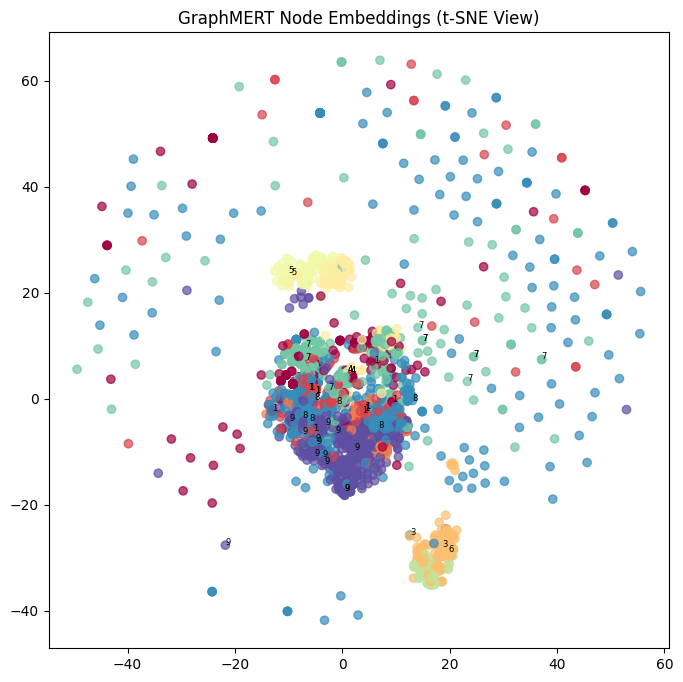

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='Spectral', alpha=0.7)
for i, text in enumerate(corpus[:50]):  # optional show partial labels
    plt.text(emb_2d[i,0]+0.01, emb_2d[i,1]+0.01, str(labels[i]), fontsize=6)
plt.title("GraphMERT Node Embeddings (t-SNE View)")
plt.show()


### GraphMERT Semantic Graph Visualization

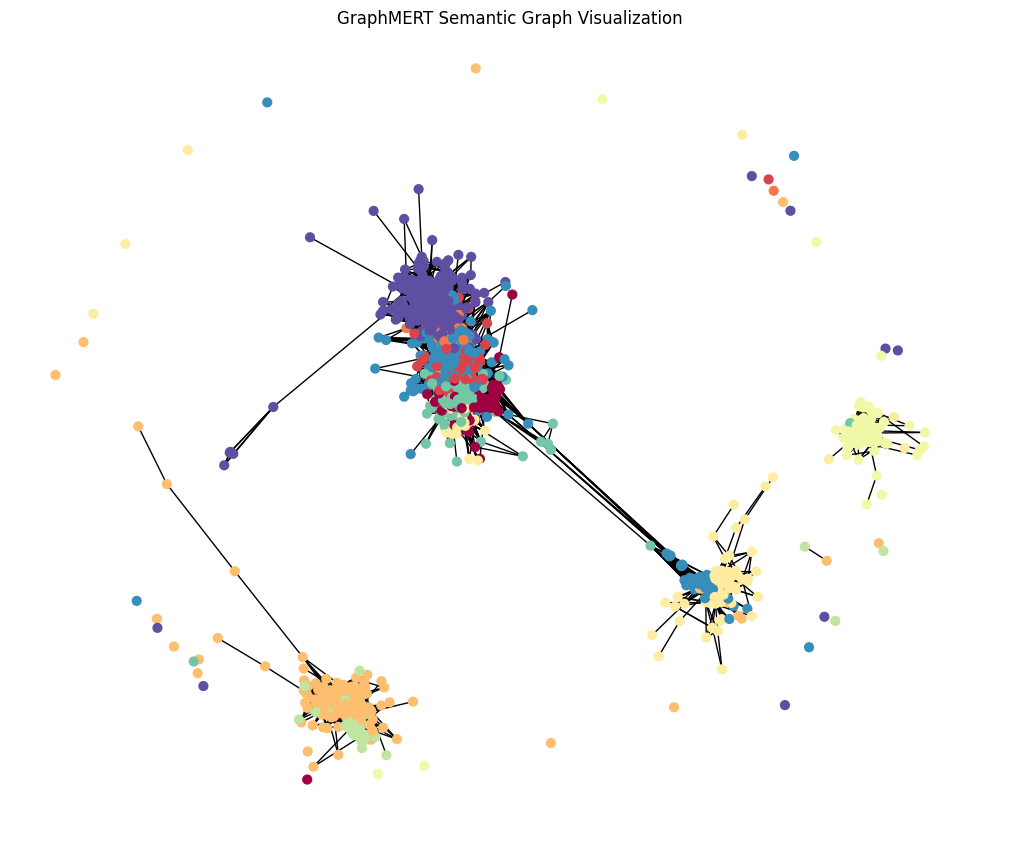

In [25]:
import networkx as nx

G = nx.Graph()
for i, emb in enumerate(embeddings):
    G.add_node(i, text=corpus[i], cluster=int(labels[i]))

# Example: connect close embeddings
from scipy.spatial.distance import pdist, squareform
dist = squareform(pdist(embeddings))
threshold = np.percentile(dist, 5)
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        if dist[i,j] < threshold:
            G.add_edge(i, j)

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=labels, cmap='Spectral', with_labels=False, node_size=40)
plt.title("GraphMERT Semantic Graph Visualization")
plt.show()


In [29]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# List nodes and edges
print("Nodes:", list(G.nodes(data=True))[:10])  # show first 10 with attributes
print("Edges:", list(G.edges(data=True))[:10])


Number of nodes: 3166
Number of edges: 231295
Nodes: [(0, {'text': 'The Project Gutenberg eBook of Romeo and Juliet\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever.', 'cluster': 8}), (1, {'text': 'You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org.', 'cluster': 8}), (2, {'text': 'If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.', 'cluster': 9}), (3, {'text': 'Title: Romeo and Juliet\n\nAuthor: William Shakespeare\n\nRelease date: November 1, 1998 [eBook #1513]\n                Most recently updated: September 18, 2025\n\nLanguage: English\n\nCredits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULI

In [30]:
# Get all neighbors of a node
node = list(G.nodes())[0]
print(f"Neighbors of {node}:", list(G.neighbors(node)))

# Check if two text nodes are connected
print(G.has_edge("sentence_12", "sentence_29"))

# Get edge attributes (e.g. similarity)
print(G.get_edge_data("sentence_12", "sentence_29"))


Neighbors of 0: [6, 11, 14, 19, 24, 30, 33, 45, 49, 53, 60, 61, 64, 72, 81, 107, 117, 123, 130, 161, 181, 182, 188, 195, 199, 204, 207, 212, 221, 223, 224, 225, 226, 228, 231, 232, 234, 235, 237, 238, 239, 241, 245, 254, 259, 260, 264, 267, 268, 272, 277, 284, 290, 294, 297, 299, 301, 303, 304, 308, 310, 314, 320, 324, 329, 330, 335, 339, 340, 346, 368, 370, 374, 375, 376, 379, 383, 386, 398, 405, 415, 418, 427, 428, 437, 451, 454, 461, 466, 471, 472, 480, 481, 487, 495, 502, 507, 515, 516, 522, 537, 546, 560, 565, 573, 575, 582, 592, 593, 596, 597, 598, 599, 608, 614, 615, 628, 631, 644, 652, 655, 664, 670, 691, 696, 707, 715, 723, 727, 728, 733, 735, 742, 744, 765, 766, 769, 770, 774, 782, 785, 787, 788, 789, 791, 794, 798, 799, 800, 806, 812, 817, 819, 823, 839, 841, 849, 866, 887, 894, 896, 900, 901, 905, 906, 909, 911, 922, 939, 968, 994, 1003, 1004, 1012, 1021, 1022, 1030, 1037, 1038, 1050, 1053, 1073, 1080, 1081, 1082, 1085, 1086, 1090, 1091, 1094, 1099, 1106, 1107, 1111, 1115, 

In [31]:
import networkx as nx

centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 influential nodes:")
for node, score in top_nodes:
    print(node, "centrality:", score)


Top 5 influential nodes:
0 centrality: 0.15671406003159558
117 centrality: 0.15671406003159558
195 centrality: 0.15671406003159558
212 centrality: 0.15671406003159558
765 centrality: 0.15671406003159558


In [32]:
# # Shortest path between two concept nodes
# path = nx.shortest_path(G, source="sentence_10", target="sentence_50")
# print("Shortest path:", path)

# # Check if graph is fully connected
# print("Is graph connected?", nx.is_connected(G))


NodeNotFound: Source sentence_10 is not in G

In [33]:
# import matplotlib.pyplot as plt

# pos = nx.spring_layout(G, seed=42)

# # Highlight a sentence cluster or subgraph
# sub_nodes = path  # highlight nodes along the shortest path
# node_colors = ['orange' if n in sub_nodes else 'lightblue' for n in G.nodes()]

# nx.draw(
#     G, pos, node_color=node_colors, with_labels=False,
#     node_size=50, edge_color='gray'
# )
# plt.title("Highlighted Knowledge Path in GraphMERT KG")
# plt.show()


NameError: name 'path' is not defined

In [ ]:
#  networkx Semantic Group Queries
for c_id in set(labels):
    cluster_group = [n for n, lbl in zip(G.nodes(), labels) if lbl == c_id]
    print(f"\nCluster {c_id}:")
    for node in cluster_group[:5]:
        print("  ", G.nodes[node].get("text", node))


# Sample GraphMERT RAG **setup**

In [43]:
import torch
import numpy as np
import networkx as nx
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
from nltk.tokenize import sent_tokenize

# Assume GraphMERTEncoder class is defined per your original code

# --- Load GraphMERT model ---
input_dim = 10
embed_dim = 32
num_heads = 4
num_layers = 2
model_path = "/content/graphmert_model.pth"

model = GraphMERTEncoder(input_dim, embed_dim, num_layers, num_heads)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# --- Load and prepare corpus ---
with open("/content/pg_sample_book.txt", "r", encoding="utf-8") as f:
    text = f.read()

corpus = sent_tokenize(text)

# --- Embed with SBERT and reduce with PCA ---
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_embeddings = sbert_model.encode(corpus)  # (N, 384)

pca_text = PCA(n_components=input_dim)
reduced_sbert_emb = pca_text.fit_transform(sbert_embeddings)  # (N, 10)

# --- Prepare inputs and run GraphMERT inference ---
input_features = torch.tensor([reduced_sbert_emb], dtype=torch.float32)  # (1, N, 10)
with torch.no_grad():
    graphmert_outputs = model(input_features)  # (1, N, 128)
graphmert_embeddings = graphmert_outputs[0].cpu().numpy()

# --- Reduce GraphMERT embeddings with separate PCA ---
pca_graphmert = PCA(n_components=input_dim)
reduced_graphmert_emb = pca_graphmert.fit_transform(graphmert_embeddings)  # (N, 10)

# --- Build NetworkX graph with text + GraphMERT PCA embeddings ---
G = nx.Graph()
for idx, (txt, emb) in enumerate(zip(corpus, reduced_graphmert_emb)):
    G.add_node(idx, text=txt, embedding=emb)
for i in range(len(corpus) - 1):
    G.add_edge(i, i + 1)

# --- Retrieval using SBERT + PCA embeddings (consistent with corpus) ---
def retrieve_similar_nodes(query, graph, sbert_model, pca_text, top_k=3):
    query_emb = sbert_model.encode([query])
    query_emb_reduced = pca_text.transform(query_emb)[0]  # Shape (10,)
    scores = []
    for node in graph.nodes:
        node_emb = graph.nodes[node]['embedding']  # GraphMERT PCA embeddings also 10-dim
        # Cosine similarity
        sim = np.dot(query_emb_reduced, node_emb) / (np.linalg.norm(query_emb_reduced) * np.linalg.norm(node_emb))
        scores.append((node, sim))
    scores.sort(key=lambda x: x[1], reverse=True)
    return [graph.nodes[n]['text'] for n, _ in scores[:top_k]]

# --- Setup generation pipeline (GPT-2 example) ---
# generator = pipeline('text-generation', model='Qwen/Qwen3-0.6B')
generator = pipeline('text-generation', model='gpt2')


def graphrag_generate(query):
    retrieved = retrieve_similar_nodes(query, G, sbert_model, pca_text)
    context = "\n".join(retrieved)
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
    results = generator(prompt, max_length=150, num_return_sequences=1)
    return results[0]['generated_text']

# --- Example usage ---
query = "What part of the story does romeo talk to the Friar about being banished?"
answer = graphrag_generate(query)
print("GraphRAG answer:\n", answer)


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GraphRAG answer:
 Context:
I shall forget, to have thee still stand there,
Remembering how I love thy company.
Go thy
ways, wench, serve God.
What, dress’d, and in your clothes, and down again?

Question: What part of the story does romeo talk to the Friar about being banished?
Answer:

I am still in my youth. I have

gone to see the Friar, and he hath spoken to me.

I can not tell you much of what he said, but I can tell

how he came to this point.

What did he say, and how did

he reply, and how many times did he respond?

Answer:

He was speaking the truth.

He said in his words, 'I shall not see you again until I learn

what is in your heart.'

Why, he said, he had not been a monk for forty years.

I cannot tell you much about what he said, but I can tell you

what he said in his speech, and what he said in his words.

The Friar:

I must return to you.

He is not a monk for forty years.

He says, 'I am still in my youth.'

In his words: 'I am not a monk for forty years.

He will no

In [44]:
# --- Example usage ---
query = "What part of the story does romeo talk to the Friar about being banished?"
answer = graphrag_generate(query)
print("GraphRAG answer:\n", answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GraphRAG answer:
 Context:
I shall forget, to have thee still stand there,
Remembering how I love thy company.
Go thy
ways, wench, serve God.
What, dress’d, and in your clothes, and down again?

Question: What part of the story does romeo talk to the Friar about being banished?
Answer:

I have some good news for you.

Romeo, he will be here.

My brother, for so long as I am here,

I have done nothing to provoke you.

We love each other.

Romeo, what is this about?

For what can you say?

The truth is, I love you.

Romeo, you are the son of the god of the land,

The man who gave you power, a man who gave you strength.

You love me, and I have been your father.

Go, you son of the gods, and remember me.

I love thee, and I love thee well.

And remember me, too, and you, and I.

Answer:

I am the one who has given thee power,

And the one who set you free.

You are the one who has given you strength,

And I love thee well.

I love thee, and I love thee well.

And remember me, and you, and

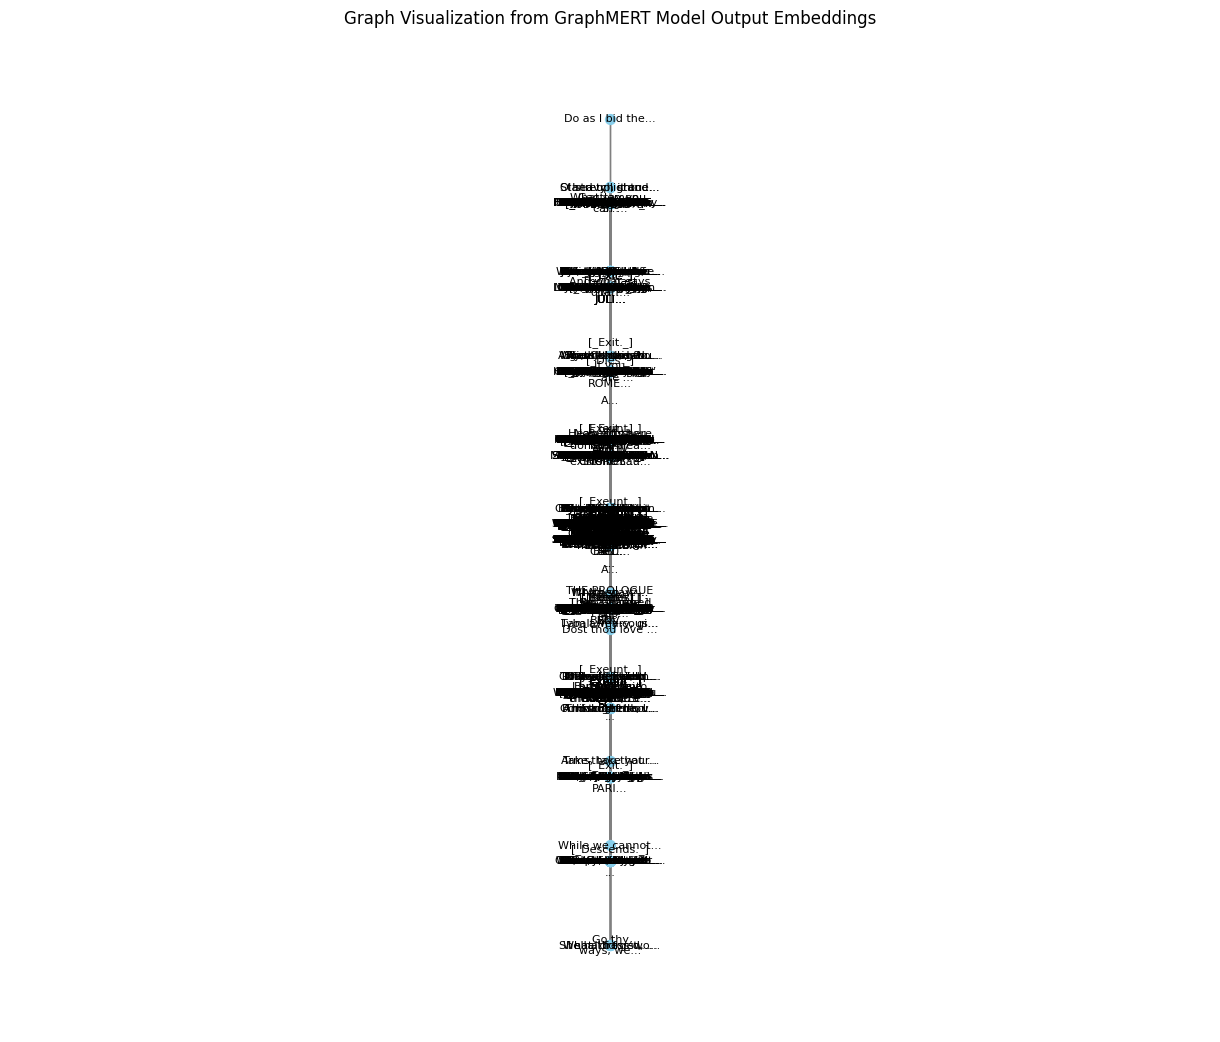

In [45]:
#  show the graphMERT response to the graphRAG query
import matplotlib.pyplot as plt
import networkx as nx

# Assume 'graphmert_outputs' is your model output tensor: shape (1, num_nodes, 128)
# and 'corpus' holds the corresponding original text chunks

embeddings = graphmert_outputs[0].cpu().numpy()  # (num_nodes, 128)

# Optionally reduce dimensionality with PCA (recommended for large feature sets)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)  # (num_nodes, 2)

# Build graph
G = nx.Graph()

# Add nodes with text and 2D positions for visualization
for i, (text, coord) in enumerate(zip(corpus, emb_2d)):
    G.add_node(i, label=text[:15]+"...", pos=coord)  # label truncated for readability

# Optionally connect sequential nodes or based on proximity for edges
for i in range(len(corpus)-1):
    G.add_edge(i, i+1)

# Get positions for plotting
pos = nx.get_node_attributes(G, 'pos')

# Draw graph with node labels truncated for clarity
plt.figure(figsize=(12,10))
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=50, font_size=8, node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization from GraphMERT Model Output Embeddings")
plt.show()